# Evolutionary Algorithms (Part 1)

The general scheme of an evolutionary algorithm is as follows:
- We need to decide on some (genetic) _encoding_ for our search problem
- The algorithm acts on a _population_ of individuals, initially usually generated randomly
- From that population a strategy of _parent selection_ decides which individuals may reproduce
- Selection is usually influenced by the _fitness_ of individuals
- _Recombination operators_ describe how parents are recombined, thereby merging genetic material from multiple parents
- As part of recombination, _mutation_ on the offspring may occur
- Which of the parents and offspring represent the next generation is determined by a _survivor selection_ strategy
- There needs to be some criterion to decide on _termination_ of the algorithm (e.g., fixed time or number of fitness evaluations)

Historically, there are different branches of evolutionary computation, and the different flavours of evolutionary algorithms have been associated with different data types to represent solutions. For example, _Genetic Algorithms_ are traditionally associated with binary strings, while _Evolution Strategies_ were mainly concerned with real-valued vectors. These differences are largely irrelevant for our purposes. An overall strategy to derive a suitable evolutionary algorithm or a problem at hand is to:
1. Choose a representation that suits the problem at hand
2. Choose variation operators based on that representation
3. Choose selection operators, which are independent of representation


In [1]:
import matplotlib.pyplot as plt
import random

We will start by considering the one-max problem again, where a solution is a vector of length _n_, consisting of binary numbers.

In [2]:
n = 20

In terms of _genetic encoding_, a _chromosome_ would in this case be the list, each number in the list is a _gene_, and the alleles would be the actual values _0_ and _1_. This _bitstring_ representation also happens to be the classical representation often used for Genetic Algorithms.

In [3]:
def get_random_solution():
    return [random.choice([0,1]) for _ in range(n)]

Like all metaheuristics, evolutionary algorithms are guided by a fitness function -- in the case of evolutionary algorithms these mainly inform the selection operators about the fitness of candidate individuals. The fitness function is independent of the metaheuristic search algorithm, but specific to the problem we are attempting to solve, so it is the same fitness function we used for local search algorithms when solving the one max problem:

In [4]:
def get_fitness(solution):
    return sum(solution)

## Evolution Strategies

Evolution Strategies were developed in the 1960s and 1970s by Ingo Rechenberg and Hans-Paul Schwefel. We will start considering canonical evolution strategies which mainly use selection and mutation.

- Ingo Rechenberg (1971): Evolutionsstrategie – Optimierung technischer Systeme nach Prinzipien der biologischen Evolution (PhD thesis). Reprinted by Frommann-Holzboog (1973).
- Hans-Paul Schwefel (1974): Numerische Optimierung von Computer-Modellen (PhD thesis). Reprinted by Birkhäuser (1977).

Classical evolution strategies were applied to real-valued vectors, where mutation was performed by adding a normally distributed random vector. In our one max example, however, we are optimising a bitvector and not a vector of real numbers. We can define a basic mutation as randomly flipping bits in a chromosome (as is the standard way to mutate bitstrings). An important question here is how many bits to flip in a vector: If the changes are too small, this inhibits the exploration aspect of the algorithm; if the changes are too large, this may inhibit exploitation. A common approach is therefore to make a probabilistic number of changes depending on the length of chromosomes used. Given a vector of length _n_, each element is changed with probability _1/n_. On average, one element will thus be changed. However, it may also happen that more or fewer elements are changed.

In [5]:
def mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = 1 - copy[position]
    return copy

In [6]:
mutate([0,0,0,0,0,0])

[0, 1, 0, 0, 0, 0]

We need to set some parameters again; first, we'll store the best solution found along the search in the list `fitness_values` again, and we will use the number of fitness evaluations as the stopping condition.

In [7]:
max_steps = 1000
fitness_values = []

To start with, we consider the simplest possible evolution strategy which operates on a population of size two: the current point (parent) and the result of its mutation (offspring). The parent selection is therefore easy -- there is only one parent. Survivor selection chooses the mutant as the next parent if its fitness is at least as good as the parent's fitness, otherwise the parent survives and the mutant is disregarded.

In [8]:
def oneplusone():
    current = get_random_solution()
    fitness = get_fitness(current)
    iteration = 0

    while iteration < max_steps:
        iteration += 1
        candidate = mutate(current)
        candidate_fitness = get_fitness(candidate)
        if candidate_fitness >= fitness:
            if candidate_fitness > fitness:
                print(f"Iteration {iteration}: Fitness {candidate_fitness}")
            current = candidate
            fitness = candidate_fitness
        fitness_values.append(fitness)

    return current

In [9]:
fitness_values = []
oneplusone()

Iteration 8: Fitness 15
Iteration 15: Fitness 16
Iteration 18: Fitness 17
Iteration 39: Fitness 18
Iteration 50: Fitness 19
Iteration 77: Fitness 20


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

To see the progress of the evolution, we can plot the fitness values again:

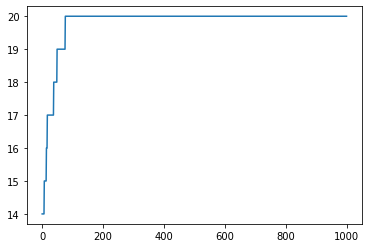

In [10]:
plt.plot(fitness_values)

The fitness plot is probably slightly less steep than the one we saw for the hillclimber in the last chapter. However, this particular evolutionary algorithm is actually a variant of hillclimbing: It is a _randomised_ (or _stochastic_) hillclimber, where the exploration operator chooses random neighbours. As the mutation operator may change more than one bit, however, we may also be making larger jumps in the search space, rather than just considering immediate neighbours.

The name "one plus one" summarises three different parameters of this evolution strategy. First, the number of offspring may differ from the number of parents. In evolution strategies, the _lambda_ parameter typically denotes how many offspring each parent produces. This generalises the (1+1)-ES to a (1+λ)-ES, where the parent produces λ offspring. The survivor selection then considers the parent as well as all mutants, and picks the best of these as the new parent.

In [11]:
lmbda = 9
def onepluslambda():
    current = get_random_solution()
    fitness = get_fitness(current)
    best_fitness = fitness
    step = 0

    while step < max_steps:
        step += lmbda
        mutants = [mutate(current) for _ in range(lmbda)]
        candidates = [(x, get_fitness(x)) for x in mutants]        
        candidates.append((current, fitness))
        current, fitness = max(candidates,key=lambda item:item[1])
        if fitness > best_fitness:
            print(f"Iteration {step}: Fitness {fitness}")
            best_fitness = fitness
        fitness_values.extend([fitness for _ in range(lmbda)])

    return current

Iteration 9: Fitness 8
Iteration 18: Fitness 10
Iteration 27: Fitness 11
Iteration 36: Fitness 12
Iteration 45: Fitness 13
Iteration 54: Fitness 14
Iteration 81: Fitness 15
Iteration 90: Fitness 17
Iteration 108: Fitness 18
Iteration 126: Fitness 19
Iteration 207: Fitness 20


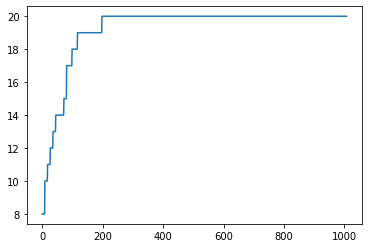

In [12]:
fitness_values = []
onepluslambda()
plt.plot(fitness_values)

Increasing λ leads to more exploration of the local neighbourhood of the current solution; intuitively, the effects will be similar like switching between steepest ascent and first ascent hillclimbers.

The second parameter is the selection strategy, which in the `onepluslambda` strategy is encoded in the name, `plus`, as it considers the parent _plus_ the offspring during selection. An alternative selection is _comma_-selection, where survivors are only selected from the offspring.

In [13]:
def onecommalambda():
    current = get_random_solution()
    fitness = get_fitness(current)
    best_fitness = fitness
    best = current[:]
    step = 0

    while step < max_steps:
        step += lmbda
        mutants = [mutate(current) for _ in range(lmbda)]
        candidates = [(x, get_fitness(x)) for x in mutants]        
        # Parent is not a candidate
        current, fitness = max(candidates,key=lambda item:item[1])
        if fitness > best_fitness:
            print(f"Iteration {step}: Fitness {fitness}")
            best_fitness = fitness
            best = current[:]
        fitness_values.extend([best_fitness for _ in range(lmbda)])

    return best

Iteration 9: Fitness 13
Iteration 18: Fitness 14
Iteration 36: Fitness 16
Iteration 54: Fitness 17
Iteration 72: Fitness 18
Iteration 117: Fitness 19
Iteration 144: Fitness 20


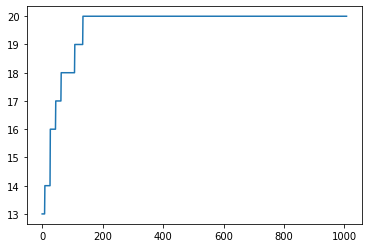

In [14]:
fitness_values = []
onecommalambda()
plt.plot(fitness_values)

We will next generalise our `one-` strategies to larger populations than just one, which represents the third parameter encoded in the name. In evolution strategies, the population size is typically denoted as μ, and we can easily generalise our (1+λ)-ES to a (μ+λ)-ES, where the μ parents produce a total of λ offspring, and then survivor selection considers all parents together with (_plus_) all their offspring.

In [15]:
mu = 3
def mupluslambda():
    population = [(x, get_fitness(x)) for x in [get_random_solution() for _ in range(mu)]]

    population.sort(key=lambda item:item[1], reverse=True)
    best = population[0][0][:]
    best_fitness = population[0][1]
    step = 0

    while step < max_steps:
        offspring = [mutate(parent) for parent, _ in random.choices(population, k=lmbda)]
        step += lmbda

        # Plus selection
        candidates = [(x, get_fitness(x)) for x in offspring] + population        
        candidates.sort(key=lambda item:item[1], reverse=True)
        population = candidates[:mu]
        
        if population[0][1] > best_fitness:
            print(f"Iteration {step}: Fitness {population[0][1]}")

        best = population[0][0][:]
        best_fitness = population[0][1]
        fitness_values.extend([best_fitness for _ in range(lmbda)])

    return best

Iteration 9: Fitness 12
Iteration 36: Fitness 13
Iteration 54: Fitness 14
Iteration 72: Fitness 15
Iteration 117: Fitness 16
Iteration 126: Fitness 17
Iteration 180: Fitness 18
Iteration 207: Fitness 19
Iteration 225: Fitness 20


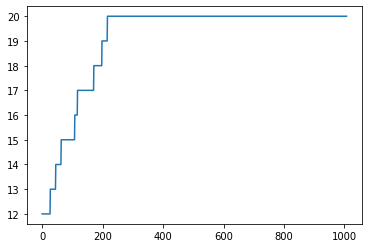

In [16]:
fitness_values = []
mupluslambda()
plt.plot(fitness_values)

While the fitness curve likely is less steep than in the former versions of the evolution strategy, note that in the plot we are only increasing once we have completed the evaluation of an entire generation.

For the sake of completeness, let's also consider the (μ,λ)-ES, where the survivor selection only considers the offspring, but not the parents. The (μ,λ)-selection is often preferred in practice because it is better at leaving local optima as well as following moving optima. Note that for (μ,λ) selection μ < λ must hold.

In [17]:
def mucommalambda():
    population = [(x, get_fitness(x)) for x in [get_random_solution() for _ in range(mu)]]

    population.sort(key=lambda item:item[1], reverse=True)
    best = population[0][0]
    best_fitness = population[0][1]
    step = 0

    while step < max_steps:
        offspring = [mutate(parent) for parent, _ in random.choices(population, k=lmbda)]
        step += lmbda

        # Comma selection
        candidates = [(x, get_fitness(x)) for x in offspring]        
        candidates.sort(key=lambda item:item[1], reverse=True)        
        population = candidates[:mu]
        
        if population[0][1] > best_fitness:
            print(f"Iteration {step}: Fitness {population[0][1]}")
            best_fitness = population[0][1]
            best = population[0][0][:]
            
        fitness_values.extend([best_fitness for _ in range(lmbda)])

    return best

Iteration 18: Fitness 15
Iteration 27: Fitness 16
Iteration 45: Fitness 17
Iteration 63: Fitness 18
Iteration 153: Fitness 19
Iteration 171: Fitness 20


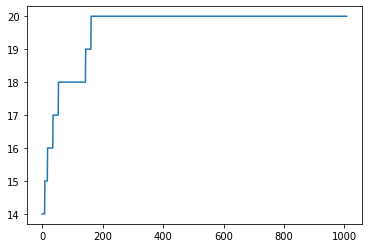

In [18]:
fitness_values = []
mucommalambda()
plt.plot(fitness_values)

The evolution strategies we have considered so far did not include recombination: We simply compied the parents. There is another parameter which we need to consider, and which was hidden from the name so far: The number of individuals involved in recombination ρ. So far, we had implicitly assumed ρ=1, which is known as _cloning_. The parameter is typically included in the name of the evolution strategy using the scheme (μ/ρ,λ). Let's consider the case of ρ=2:

In [19]:
rho = 2

In order to combine to parents, we need to combine two parents to one offspring. Crossover takes the genetic material of two or more parent individuals, and recombines them. A basic crossover operator is single-point crossover, where, for two parent chromosomes of length n, we pick a point 0 < x < n, and then take the first x genes from the first parent, and the remaining n - x genes from the second parent. Crossover can be implemented to return a single combined individual, or we can return both variants (and if we only need one, we can randomly choose one).

In [20]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return offspring1, offspring2

Integrating crossover (ρ=2) into our evolution strategies gives us a (μ/2+λ) algorithm:

In [21]:
def mu2pluslambda():
    population = [(x, get_fitness(x)) for x in [get_random_solution() for _ in range(mu)]]

    population.sort(key=lambda item:item[1], reverse=True)
    best = population[0][0][:]
    best_fitness = population[0][1]
    step = 0

    while step < max_steps:
        offspring = []
        for x in range(lmbda):
            parents = [ parent for parent, _ in random.choices(population, k=2) ]            
            child = random.choice(singlepoint_crossover(parents[0], parents[1]))
            child = mutate(child)
            offspring.append(child)
            step += 1
            
        # Plus selection
        candidates = [(x, get_fitness(x)) for x in offspring] + population        
        candidates.sort(key=lambda item:item[1], reverse=True)
        population = candidates[:mu]
        
        if population[0][1] > best_fitness:
            print(f"Iteration {step}: Fitness {population[0][1]}")

        best = population[0][0][:]
        best_fitness = population[0][1]
        fitness_values.extend([best_fitness for _ in range(lmbda)])

    return best

Iteration 9: Fitness 13
Iteration 18: Fitness 14
Iteration 27: Fitness 15
Iteration 63: Fitness 16
Iteration 81: Fitness 17
Iteration 99: Fitness 18
Iteration 117: Fitness 19
Iteration 135: Fitness 20


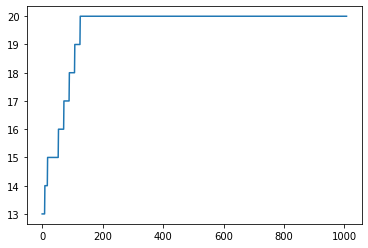

In [22]:
fitness_values = []
mu2pluslambda()
plt.plot(fitness_values)

Of course we also have a comma-selection variant:

In [23]:
def mu2commalambda():
    population = [(x, get_fitness(x)) for x in [get_random_solution() for _ in range(mu)]]

    population.sort(key=lambda item:item[1], reverse=True)
    best = population[0][0][:]
    best_fitness = population[0][1]
    step = 0

    while step < max_steps:
        offspring = []
        for x in range(lmbda):
            parents = [ parent for parent, _ in random.choices(population, k=2) ]            
            child = random.choice(singlepoint_crossover(parents[0], parents[1]))
            child = mutate(child)
            offspring.append(child)
            step += 1
            
        # Comma selection
        candidates = [(x, get_fitness(x)) for x in offspring]
        candidates.sort(key=lambda item:item[1], reverse=True)
        population = candidates[:mu]
        
        if population[0][1] > best_fitness:
            print(f"Iteration {step}: Fitness {population[0][1]}")
            best_fitness = population[0][1]
            best = population[0][0][:]

        fitness_values.extend([best_fitness for _ in range(lmbda)])

    return best

Iteration 18: Fitness 15
Iteration 45: Fitness 16
Iteration 54: Fitness 17
Iteration 81: Fitness 18
Iteration 99: Fitness 19
Iteration 234: Fitness 20


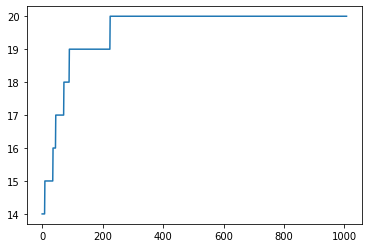

In [24]:
fitness_values = []
mu2commalambda()
plt.plot(fitness_values)

An important element of evolution strategies in general we haven't touched upon yet is self-adaptation -- which is a topic we will consider in a later lecture.

## Simple Genetic Algorithm

Traditionally, a main difference between evolution strategies and genetic algorithms is that evolution strategies manipulate the phenotype directly, since they were originally applied to real-values functions. In contrast, genetic algorithms traditionally act on a genetic encoding (usually binary encoding), and the fitness is evaluated on the decoded phenotype. For our one max example, the difference is rather irrelevant, since our phenotype _is_ a bitstring.

A second major difference lies in the selection strategy: In a canonical, simple Genetic Algorithm the deterministic parent selection is usually replaced with a probabilistic selection strategy, typically applied to larger populations. As a simple first example, we will use tournament selection: For a given number of individuals (the tournament size) we randomly select individuals from the population (with or without replacement), and the best of these individuals wins the tournament, and is a parent for reproduction.

In [25]:
tournament_size = 5
def tournament_selection(population, replacement=False):
    if replacement:
        candidates = random.choices(population, k=tournament_size)
    else:
        candidates = random.sample(population, tournament_size)
        
    winner, fitness = max([(x, get_fitness(x)) for x in candidates], key=lambda item:item[1])
    return winner

Note: We are redundantly calculating fitness here. However, we will not count these fitness evaluations as it would be trivial to cache fitness values to avoid recalculation, but that would clutter up the examples. (We will cache fitness values in later iterations of the algorithms we are considering).

For survivor selection, there are different models: In a _generational_ genetic algorithm, an entire new offspring population is bred, and then replaces the parent population. In a _steady-state_ genetic algorithm, one offspring (or pair of offspring) is generated per generation and one member of population is replaced by that offspring. We will start with a generational genetic algorithm, but include another twist on survivor selection: In _elitism_ a certain share of the best individuals of one generation survives _unchanged_ to the next generation:

In [26]:
def elitism(population):
    population.sort(key=lambda k: get_fitness(k), reverse=True)
    return population[:elite_size]

Before we implement the genetic algorithm, there are a couple of parameters we need to decide on: How large shall the population be? How many of these shall always survive based on elitism? What should the probability for mutation be? While we have avoided the question of the mutation rate by encoding that into the mutation operator, we need to choose sensible values for all other parameters. We will use some common default values:

In [27]:
population_size = 20
elite_size = int(population_size * 0.05)
P_xover = 0.7
selection = tournament_selection
crossover = singlepoint_crossover
fitness_values = []

In [28]:
def ga():
    population = [get_random_solution() for _ in range(population_size)]

    # This could probably be written in a single line, but let's keep it explicit
    best_fitness = -1
    step = 0
    for p in population:
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = p
        step += 1
        fitness_values.append(best_fitness)

    iteration = 0
    print(f"Iteration {iteration}, best fitness: {best_fitness}")
    while step < max_steps:
        iteration += 1
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1[:], parent2[:]

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            new_population += [offspring1, offspring2]

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            step += 1
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = p
                print(f"Iteration {iteration}, best fitness: {best_fitness}")
            fitness_values.append(best_fitness)

    return best_solution


Iteration 0, best fitness: 13
Iteration 1, best fitness: 15
Iteration 2, best fitness: 16
Iteration 4, best fitness: 17
Iteration 4, best fitness: 18
Iteration 6, best fitness: 19
Iteration 12, best fitness: 20


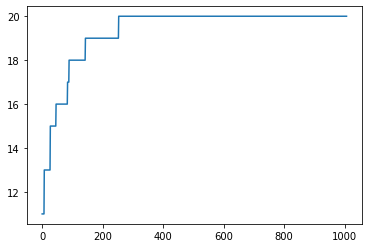

In [29]:
fitness_values = []
ga()
plt.plot(fitness_values)

### Steady State Genetic Algorithm

Our simple genetic algorithm uses a _generational model_, where each iteration produces a new offspring population. An alternative is a _steady state_ genetic algorithm: In each iteration, we only pick a small number of individuals (e.g., 2), produce offspring, and then replace the parents with the offspring. During this replacement we can apply differnet survivor strategies; for example, the offspring can always replace the parents, of we could always use the best out of the set of parents and their offspring.

In [30]:
def steadystatega():
    population = [get_random_solution() for _ in range(population_size)]
    best_fitness = -1
    step = 0
    for p in population:
        fitness = get_fitness(p)
        step += 1
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = p
        fitness_values.append(best_fitness)
    print(f"Iteration 0, best fitness: {best_fitness}")

    iteration = 0
    while step < max_steps:
        iteration += 1
                
        parent1 = selection(population)
        parent2 = selection(population)
        
        p1 = population.index(parent1)
        p2 = population.index(parent2)

        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1[:], parent2[:]

        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)
        
        best1, best2 = sorted([parent1, parent2, offspring1, offspring2], key=lambda item:get_fitness(item), reverse=True)[:2]
        population[p1] = best1
        population[p2] = best2
        step += 2

        if get_fitness(best1) > best_fitness or get_fitness(best2) > best_fitness:
            best_fitness = max(get_fitness(best1), get_fitness(best1))
            print(f"Iteration {iteration}, best fitness: {best_fitness}")

        fitness_values.append(best_fitness)
        fitness_values.append(best_fitness)

    return best_solution


Iteration 0, best fitness: 13
Iteration 2, best fitness: 15
Iteration 34, best fitness: 16
Iteration 50, best fitness: 17
Iteration 59, best fitness: 18
Iteration 62, best fitness: 19
Iteration 91, best fitness: 20


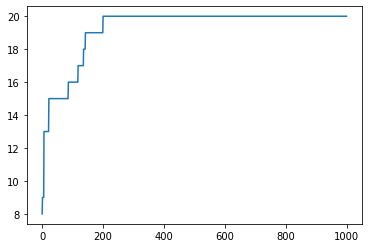

In [31]:
fitness_values = []
steadystatega()
plt.plot(fitness_values)

## Comparison of the algorithms

We defined a rather large space of possible algorithms and variations, and the usual question is: Which of these works best? The answer to this, as usual, is: It depends. Let's evaluate some variants.

To simplify experiments, we will define a helper function that runs an algorithm for a number of repetitions and gives us a list of resulting fitness values.

In [32]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values
    result = []
    for i in range(repetitions):
        fitness_values = []
        with io.capture_output() as captured: 
            algorithm()
        result.append(fitness_values[-1])
    return result

As we saw in the previous examples, one max for `n=20` is a pretty easy problem for evolutionary algorithms, so let's increase difficulty somewhat:

In [33]:
n = 100

In [34]:
crossover = singlepoint_crossover
selection = tournament_selection
max_steps = 1000

results = {"GA"      : run_times(ga, 30), 
           "SS-GA"   : run_times(steadystatega, 30),
           "(μ/2+λ)EA" : run_times(mu2pluslambda, 30),
           "(μ/2,λ)EA" : run_times(mu2commalambda, 30),
           "(μ+λ)EA" : run_times(mupluslambda, 30),
           "(μ,λ)EA" : run_times(mucommalambda, 30),
           "(1+1)EA" : run_times(oneplusone, 30), }
print(results)

{'GA': [97, 92, 97, 97, 92, 97, 93, 95, 95, 100, 98, 97, 92, 96, 97, 95, 94, 95, 97, 98, 95, 96, 95, 97, 96, 96, 97, 95, 95, 95], 'SS-GA': [95, 95, 94, 94, 92, 94, 92, 93, 94, 98, 98, 92, 91, 94, 97, 93, 93, 93, 94, 92, 89, 98, 94, 94, 94, 93, 89, 95, 97, 95], '(μ/2+λ)EA': [100, 100, 99, 99, 100, 100, 100, 100, 99, 98, 99, 100, 99, 97, 98, 99, 98, 98, 99, 99, 98, 99, 100, 99, 99, 99, 99, 99, 100, 98], '(μ/2,λ)EA': [99, 96, 97, 97, 97, 97, 96, 97, 96, 98, 95, 98, 99, 99, 99, 99, 97, 98, 97, 97, 94, 97, 99, 97, 97, 98, 96, 96, 98, 97], '(μ+λ)EA': [96, 97, 98, 99, 99, 99, 98, 97, 99, 94, 98, 96, 96, 98, 98, 96, 97, 98, 97, 100, 96, 99, 99, 98, 99, 97, 95, 100, 96, 97], '(μ,λ)EA': [95, 97, 94, 92, 94, 96, 98, 92, 92, 93, 96, 95, 96, 94, 93, 92, 93, 96, 94, 94, 95, 94, 96, 92, 95, 92, 94, 95, 94, 95], '(1+1)EA': [98, 99, 99, 99, 100, 100, 100, 98, 100, 99, 100, 100, 100, 100, 99, 98, 100, 100, 99, 98, 99, 100, 100, 99, 100, 100, 99, 100, 100, 100]}


We can compare the results by plotting the distributions of the final fitness values:

[Text(1, 0, 'GA'),
 Text(2, 0, 'SS-GA'),
 Text(3, 0, '(μ/2+λ)EA'),
 Text(4, 0, '(μ/2,λ)EA'),
 Text(5, 0, '(μ+λ)EA'),
 Text(6, 0, '(μ,λ)EA'),
 Text(7, 0, '(1+1)EA')]

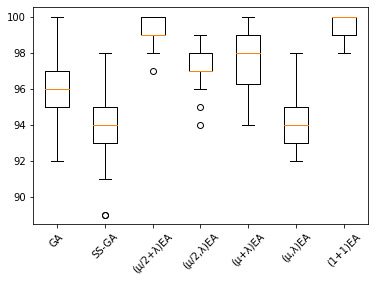

In [35]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys(), rotation=45)

Most likely, the results suggest that (1+1)ES finds the solution for one max more efficiently (but whether it does so significantly we would have to test for using statistical tests and effect size measures). We only looked at one particular configuration of search operators for the GA, and varying the parameters and operators may lead to entirely different results. We will look at other operators in the next chapter. Let's first look if our experiment generalises to other problems.

## Evolutionary Search on the n-queens problem

As alternative example problem, we will consider the n-queens problem again, which you already know from the previous chapter:

In [36]:
def get_random_solution():
    return [random.randint(0, n-1) for _ in range(n)]

To keep the runtimes of the algorithms small, we should reduce the value of `n` compared to what we used for one max:

In [37]:
n = 20

The fitness calculation still considers the number of pairs of queens that do not check each other:

In [38]:
def get_fitness(solution):
    fitness = 0
    for i in range(len(solution) - 1):
        for j in range(i + 1, len(solution)):
            if solution[i] != solution[j] \
                and solution[i] != solution[j] + (j - i) \
                and solution[j] != solution[i] + (j - i):
                fitness += 1

    return fitness

In order to apply search to a different problem, we also need to make sure that the search operators match the problem encoding. Selection operators are independent of the representation, so we only need to worry about variation operators here. For crossover, we are just cutting and merging lists, so the single-point crossover operator we defined is just fine for the n-queens problem. We will have to change our mutation operator, however, since for one max that simply consists of flipping bits. As a basic mutation operator, we can simply probabilistically replace individual genes with new random values:

In [39]:
def mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = random.randint(0, n-1)
    return copy

Let's also revisit the local search algorithms we defined in the previous chapter. (In a future revision of this notebook I'll just import them, but for now they are cloned below).

In [40]:
def get_neighbours(solution):
    neighbours = []
    for i in range(len(solution)):
        if solution[i] > 0:
            copy = solution[:]
            copy[i] = copy[i] - 1
            neighbours.append(copy)
        if solution[i] < n - 1:
            copy = solution[:]
            copy[i] = copy[i] + 1
            neighbours.append(copy)

    return neighbours

In [41]:
def hillclimbing():

    current = get_random_solution()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    print(f"Starting at fitness {best_fitness}: {current}")

    step = 0
    while step < max_steps:

        replaced = False
        for neighbour in get_neighbours(current):
            neighbour_fitness = get_fitness(neighbour)
            step += 1
            if neighbour_fitness > fitness:
                current = neighbour
                fitness = neighbour_fitness
                replaced = True
                if fitness > best_fitness:
                    print(f"Iteration {step}, fitness {best_fitness}: {best}")
                    best = current[:]
                    best_fitness = fitness

                fitness_values.append(best_fitness)
                break
            else:
                fitness_values.append(best_fitness)

        # Random restart if no neighbour is better
        if not replaced:
            current = get_random_solution()
            fitness = get_fitness(current)
            step += 1
            if fitness > best_fitness:
                print(f"Iteration {step}, fitness {best_fitness}: {best}")
                best = current[:]
                best_fitness = fitness
                fitness_values.append(best_fitness)


    print(f"Solution fitness {best_fitness}: {best}")
    return best

In [42]:
def tabusearch():
    current = get_random_solution()
    fitness = get_fitness(current)

    tabu = [current]

    best_solution = current
    best_fitness = fitness

    print(f"Initial solution: {current} fitness {fitness}")

    iteration = 0
    step = 0
    while step < max_steps:
        best_neighbour = None

        neighbour_fitness = 0
        for neighbour in get_neighbours(current):
            if neighbour not in tabu:
                new_fitness = get_fitness(neighbour)
                step += 1
                if new_fitness > neighbour_fitness:
                    best_neighbour = neighbour
                    neighbour_fitness = new_fitness
                    if neighbour_fitness > best_fitness:
                        best_fitness = neighbour_fitness
                        best_solution = best_neighbour
                        print(f"Iteration: {iteration}, fitness {best_fitness}, steps {step}")
                fitness_values.append(best_fitness)
                

        # Append at the end of the tabu list
        tabu.append(best_neighbour)
        current = best_neighbour
        
        # Remove elements from the front of the tabu list
        while len(tabu) > tabu_size:
            tabu.pop(0)
        
        iteration += 1


    print(f"Final solution: {best_solution} fitness {best_fitness} in {step} steps")

    return best_solution

In [43]:
import math
def acceptance_probability(fitness, new_fitness, temperature):
    if new_fitness > fitness:
        return 1
    else:
        p = math.exp( (new_fitness - fitness) / temperature)
        return p

def temperature(fraction):
    return max(0.01, min(1, 1 - fraction))

def simulatedannealing():
    current = get_random_solution()
    fitness = get_fitness(current)

    best_solution = current
    best_fitness = fitness

    step = 0
    print(f"Initial solution: {current} fitness {fitness}")

    while step < max_steps:
        fraction = step / float(max_steps)
        T = temperature(fraction)

        neighbour = random.choice(get_neighbours(current))
        neighbour_fitness = get_fitness(neighbour)
        step += 1

        if acceptance_probability(fitness, neighbour_fitness, T) > random.random():
            current, fitness = neighbour, neighbour_fitness

            if fitness > best_fitness:
                print(f"Current solution: {current} fitness {fitness}, step {step}")
                best_fitness = fitness
                best_solution = current
        fitness_values.append(best_fitness)


    print(f"Final solution: {best_solution} fitness {best_fitness} in {step} steps")

    return best_solution

Now we can run some experiments using all the different search algorithms defined so far:

In [44]:
max_steps = 1000
tabu_size = 500

results = {"GA"        : run_times(ga, 30), 
           "SS-GA"     : run_times(steadystatega, 30),
           "(μ/2+λ)EA" : run_times(mu2pluslambda, 30),
           "(μ/2,λ)EA" : run_times(mu2commalambda, 30),
           "(μ+λ)"     : run_times(mupluslambda, 30),
           "(μ,λ)"     : run_times(mucommalambda, 30),
           "(1+1)"     : run_times(oneplusone, 30), 
           "HC"        : run_times(hillclimbing, 30),
           "Tabu"      : run_times(tabusearch, 30),
           "SA"        : run_times(simulatedannealing, 30)
          }

[Text(1, 0, 'GA'),
 Text(2, 0, 'SS-GA'),
 Text(3, 0, '(μ/2+λ)EA'),
 Text(4, 0, '(μ/2,λ)EA'),
 Text(5, 0, '(μ+λ)'),
 Text(6, 0, '(μ,λ)'),
 Text(7, 0, '(1+1)'),
 Text(8, 0, 'HC'),
 Text(9, 0, 'Tabu'),
 Text(10, 0, 'SA')]

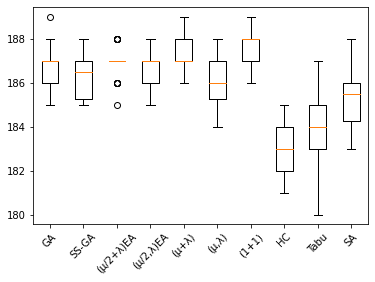

In [45]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys(), rotation=45)

At this point, we could also dig into more statistics on the comparisons. But did we really choose the right operators and parameters? This is a question for a future chapter.

## Outlook

In this chapter, we considered some basic variation and selection operators. In the next chapter we will consider a couple of alternatives. Besides all the possible variations in parameters and search operators, there are also many variations of the algorithms themselves. Some specific variants we will consider in later lectures in this course are the following:

- Parallel GAs, in which independent island populations are evolved and sporadically exchange individuals
- Cellular GAs, in which a topology is imposed on the population, and decides on candidates for reproduction
- Memetic Algorithms, which extend GAs with local search
- Adaptive GAs, in which the parameters evolve together with the solutions.

Besides these fundamental variations of the canonical GA, each variant further has many different options. What population size to use? Which selection operator? Which replacement operator? What probabilities to apply the different variation operators? We will consider in a future lecture how to choose these parameters.
